# Simulator For TRPL Data

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import numpy as np
import pandas as pd
import pytensor.tensor as at
from pytensor import *
from pytensor import config
config.allow_gc = False
import matplotlib.pyplot as plt

### Oxford color scheme
base_color = "#002147"
color_scheme = ["#44687d", "#69913b", '#cf7a30', '#be0f34']
highlight_color = "#ac48bf"

line_type_list = ['-', '-.', '--', ':']

centimeters = 1/2.54
fontsize_base = 11
figure_width = 21


# Model

In [94]:
def X_n_maker(d_factor, x_size, dx, D, Sf, Sb):

    Xn_1 = at.extra_ops.fill_diagonal_offset(x_size, d_factor, -1)
    
    Xn_2a = at.extra_ops.fill_diagonal_offset(x_size, 1-2.*d_factor, 0)
    Xn_2a1 = at.set_subtensor(Xn_2a[0,0],1-d_factor - (dx/D)*d_factor *Sf)
    Xn_2 = at.set_subtensor(Xn_2a1[-1,-1],1-d_factor - (dx/D)*d_factor *Sb)
    
    Xn_3 = at.extra_ops.fill_diagonal_offset(x_size, d_factor, 1)
    
    return Xn_1 + Xn_2 + Xn_3


def X_n_maker2(d_factor, size, dx, D, Sf, Sb):
    #size = at.shape(x_size)[0]
    
    # Step 1: Create the main diagonal and off-diagonals (scipy.sparse)
    # Create main diagonal values: first_value, middle_value, last_value
    first_value = 1 - d_factor - (dx / D) * d_factor * Sf
    last_value = 1 - d_factor - (dx / D) * d_factor * Sb
    middle_value = 1 - 2 * d_factor
    
    # Create arrays for the diagonals
    main_diag = [first_value] + [middle_value] * (size - 2) + [last_value]
    off_diag = [-d_factor] * (size - 1)

    # Step 2: Create the row indices and column indices for the sparse matrix
    row_indices = list(range(size))
    col_indices = list(range(size))

    # Step 3: Combine the values and indices for the sparse matrix in CSC format
    # First, construct the main diagonal and off-diagonal
    data = main_diag + off_diag + off_diag  # Concatenate diagonal values
    indices = row_indices + col_indices  # Row indices and column indices
    indptr = [0, size, size + (size - 1)]  # Index pointer for rows

    # Create the sparse matrix in CSC format (could also use CSR depending on usage)
    sparse_matrix_csc = sp.csc_matrix((data, indices, indptr), shape=(size, size))

    # Convert to a pytensor sparse tensor using csr_matrix (or csc_matrix if needed)
    A_n_sparse = pytensor.sparse.CSR(sparse_matrix_csc.data, sparse_matrix_csc.indices, sparse_matrix_csc.indptr, shape=sparse_matrix_csc.shape)

    return main_diag





### First: Define Rate equations
### First: Define Rate equations
def rate_equations(n_dens, nt, params):            

    k_c, k_deep, k_e, k_rad, k_aug, _, _, _, _ = params
    
    p_dens = n_dens + nt

    R_rad = - k_rad*n_dens*p_dens
    
    dnt_dt = k_c*n_dens - k_e*nt
    R_nr = - k_c*n_dens + k_e*nt - k_deep*n_dens
    
    dn_dt = R_rad + R_nr
    
    return dn_dt, dnt_dt


def Runge_Kutta_R4(n_dens, nt, dt, params):

    RuKu1_n, RuKu1_nt = rate_equations(n_dens, nt, params)
    RuKu2_n, RuKu2_nt = rate_equations(n_dens + RuKu1_n*dt/2, nt + RuKu1_nt*dt/2, params)
    RuKu3_n, RuKu3_nt = rate_equations(n_dens + RuKu2_n*dt/2, nt + RuKu2_nt*dt/2, params)
    RuKu4_n, RuKu4_nt = rate_equations(n_dens + RuKu3_n*dt, nt + RuKu3_nt*dt, params)

    Ruku_n = (RuKu1_n + 2*RuKu2_n + 2*RuKu3_n + RuKu4_n)/6
    Ruku_nt = (RuKu1_nt + 2*RuKu2_nt + 2*RuKu3_nt + RuKu4_nt)/6

    return Ruku_n, Ruku_nt


### Looping over time-domain
def total_recombination_rate(dt_current, n_dens, p_dens, ds, x_size, params):

    _, _, _, _, _, _, D, S_f, S_b = params

    # a. Recombination (Runge-Kutta Algorithm)
    nt = p_dens - n_dens
    Ruku_n, Ruku_nt  = Runge_Kutta_R4(n_dens, nt, dt_current, params)
    
    # b. Diffusion
    d_factor = D*dt_current/(2*ds*ds)
    A_n = X_n_maker2(-d_factor, x_size, ds, D, S_f, S_b)
    B_n = X_n_maker2(d_factor, x_size, ds, D, S_f, S_b)

    Bn_dot_n_dens = at.dot(B_n, n_dens) + Ruku_n*dt_current#/2
    n_dens_new = at.slinalg.solve(A_n, Bn_dot_n_dens) # at.dot(at.linalg.inv(A_n), Bn_dot_n_dens)

    # c. Physical limits
    n_dens_new = at.switch(at.le(n_dens_new, 0), 0, n_dens_new)
    p_dens_new = n_dens_new + nt + Ruku_nt*dt_current
    p_dens_new = at.switch(at.le(p_dens_new, 0), 0, p_dens_new)
    
    return n_dens_new, p_dens_new

In [95]:
D = 0.025*1e8

d_factor = D*1e-9/(2*0.1*0.1)

x_size = at.ones(shape=(100,100))
Sf = 0.1
Sb = 0.1


An = X_n_maker2(d_factor, x_size, 1e-9, D, Sf, Sb)

print(at.shape(An).eval())
print(An.eval())

TypeError: 'TensorVariable' object cannot be interpreted as an integer

In [91]:
def model_in_pytensor(time, Fluence, thickness, Absorption_coeff, p0, S_front_value, S_back_value, mu_vert, k_rad, k_deep, k_c, k_e):
    
    ## Define the spacial and temporal domains

    x = np.arange(0,thickness,30)
    z_array_np = x*1e-3
    z_array = at.as_tensor_variable(z_array_np)

    ds = at.as_tensor_variable(z_array_np[1]-z_array_np[0])
    dt = at.extra_ops.diff(time)   
    
    # Diffusion Coeffient in cm2 s-1
    limit_mobility = (thickness*1e-7)**2/(at.abs(time[1]-time[0]))/(1.380649e-23*292/1.6021766e-19)  #cm2 (Vs)-1
    Diffusion_coefficient = mu_vert*(1.380649e-23*292/1.6021766e-19)*1e8

    
    # Packing parameters
    params = k_c, k_deep, k_e, k_rad, 0, 0, Diffusion_coefficient, S_front_value, S_back_value
    
    # Initial Charge-Carrier Density
    Absorption_coeff = at.switch(at.ge(mu_vert, limit_mobility/4), 0, Absorption_coeff)
    
    generation = at.exp(-Absorption_coeff*z_array)
    generation_sum = at.sum(((generation[1:] + generation[:-1])/2), axis=0) * ds
    n_0z = Fluence/(generation_sum) * generation
    
    x_size = at.zeros(shape=(at.shape(n_0z),at.shape(n_0z)))
    
    result_one_sample, _ = pytensor.scan(fn=total_recombination_rate,
                                            sequences=[dt],
                                            outputs_info=[n_0z, n_0z+p0],
                                            non_sequences=[ds, x_size, params], strict=True)    

    n_init = (n_0z).dimshuffle('x',0)
    N_calc = at.concatenate([n_init, result_one_sample[0]], axis=0)
    p_init = (n_0z + p0).dimshuffle('x',0)
    P_calc = at.concatenate([p_init, result_one_sample[1]], axis=0)
 
    ## Turn radiative recombination into PL response    
    Rrad_calc = N_calc * P_calc
    
    PL_calc = at.sum(((Rrad_calc[:,1:] + Rrad_calc[:,:-1])/2), axis=1) * ds
    
    PL_0 = PL_calc[0]

    PL_obs = PL_calc/PL_0    
    return PL_obs, N_calc, P_calc


## Main Part

In [92]:
# Parameter Definition
Sfront = 150 #cm s-1
Sback = 500 #cm s-1
Mobility = 0.5 #cm2 V-1s-1


Fluence = 4.8e11   #cm-2

alpha = 3e5  #cm-1
Thickness = 600   #nm

k_rad = 1e-10   #cm3 s-1
p0 = 0#   #cm-3


k_deep = 1e6   #s-1
k_c = 1e6
k_e = 1e4

time = np.logspace(-1,2.8,200) #ns

df_save = pd.DataFrame()
df_save[f'Time'] = time

PL, n_dens, p_dens = model_in_pytensor(time*1e-9, Fluence*1e-8, Thickness, alpha*1e-4, p0*1e-12, Sfront*1e4, Sback*1e4, Mobility, k_rad*1e12, k_deep, k_c, k_e)


TypeError: 'TensorVariable' object cannot be interpreted as an integer

In [85]:
n = n_dens.eval() * 1e12
p = p_dens.eval() * 1e12
PL = PL.eval()

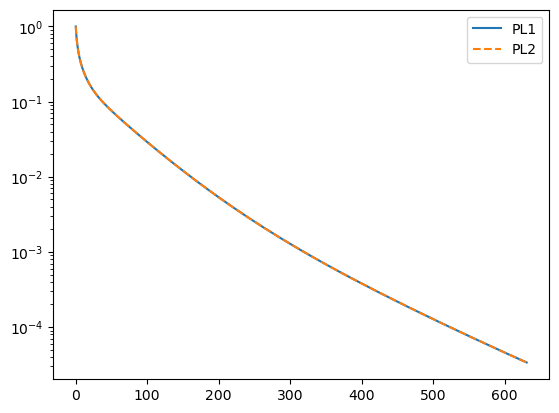

In [86]:
plt.plot(time, PL1, label='PL1')
plt.plot(time, PL, label='PL2', linestyle='--')
plt.yscale('log')
plt.legend()